# COCO Project 2023

## Introduction

Vertical Takeoff, Vertical Landing (VTVL) is a form of takeoff and landing for rockets which can allow for reusability. Perhaps the most widely known and successful reusable VTVL vehicle is [SpaceX's Falcon 9](https://www.spacex.com/vehicles/falcon-9/) first stage. Reusable rocket technology has been studied extensively in the last two decades, thanks to its many advantages over non-reusable flight systems. These include drastically lowered launch costs, rapid reusability, and reducing the environmental impacts associated with manufacturing.

In this project, you will simulate the final phase of a VTVL misson profile, which is the vertical landing phase. A [Gymnasium](https://gymnasium.farama.org) environment has been developed which simulates the simplified 2D dynamics of a VTVL rocket using the [Box2D](https://box2d.org) physics engine.

The goal of this project is to work in this environment and to develop controllers which are able to guide the descent of the rocket and bring it safely to the landing spot.

<font color='red'>NOTE</font>: We would advise you to run your code in this Colab notebook, which contains the specifications of the control problem, the linearized matrices of the rocket and the simulator with a basic PID controller already implemented and working. This will help to avoid any compatibility issues across different systems, which we may not be able to help resolve.

## Rocket Dynamics, State, and Action Spaces


A free body diagram illustrating the forces acting on the simplified 2D rocket is shown below. Note that we do not consider air resistance or aerodynamic effects in the 2D model, for simplicity.


<img src="https://gitlab.ethz.ch/bsaverio/coco-project/-/raw/main/images/Rocket_Dynamics.png" width=400/>

### Actions
Three inputs are available for steering the rocket:
- $F_E$: the thrust produced by the main engine in Newtons (N), acting directly on the rocket body at the point where the nozzle pivots;
- $F_S$: the thrust produced by the side gas thrusters in Newtons (N), defined as the difference $F_L - F_R$, acting at a distance $l_2$ from the rocket center of mass;
- $\phi$: the angle of the nozzle with respect to the rocket body in radians (rad), which changes the direction of $F_E$. It can be discontinuous and it has instant response up to the 60 fps frame rate of our model (sampling time of the environment).

The three inputs are provided to the environment as an action:

$$\textbf{u} = \begin{bmatrix}F_E & F_S & \phi\end{bmatrix}$$

which is applied to the environment at the 60 fps frame rate. In other words, your controller must provide 60 actions per second of simulation time. These could be new actions, or the same action could be applied across multiple simulation steps.

Unlike the real world, there is no hard constraint on how long your controller has to produce a next action, although we should be able to run your code in a reasonable amount of time. In our own testing, a well performing optimization-based method took much less than 1 minute to run.

<font color='red'>IMPORTANT</font>: The controller should return *normalized* actions, as a fraction of full scale. The main engine thrust is clipped to $[0, 1]$, while the side engine thrust and nozzle angle is clipped to $[-1, 1]$. The environment then scales these to the appropriate ranges (see *Limits on the Actuators*).


### State Variables
The state of the rocket is defined by the following variables:
- $(x, y)$: the 2D position of the rocket center of mass in meters (m);
- $(\dot{x}, \dot{y})$: the velocity of the rocket in meters per second (m/s);
- $\theta$: the angle of the rocket in radians (rad);
- $\dot{\theta}$: the angular velocity of the rocket in radians per second (rad/s);
- $c_L, c_R$: binary variables indicating whether the left or right legs are in contact with the environment, respectively (equal to 0 otherwise).

The environment returns these variables as an observation:
$$\textbf{x} = \begin{bmatrix}x & y & \dot{x} & \dot{y} & \theta & \dot{\theta}& c_L & c_R\end{bmatrix}$$

The last two variables ($c_L, c_R$) may generally be ignored in your control implementation, but may be useful e.g. for turning off one or more actions once ground contact is made.

<font color='red'>IMPORTANT</font>: All variables are with respect to world frame, which is located in the *bottom-left* corner of the simulation window. The x-axis increases going right (horizontally) along the window and the y-axis increases going up (vertically). Positive angles are measured counter-clockwise from the y-axis.

## Installation

The following lines of code install the `coco_rocket_lander` project package:

In [1]:
%%capture
# comment out the above line to display output

!apt install -y swig

%pip install --upgrade pip
%pip install poetry
%pip install 'git+https://gitlab.ethz.ch/bsaverio/coco-project.git@main'

# for rendering video
%pip install pyvirtualdisplay imageio-ffmpeg "moviepy>=1.0"
!apt-get install -y xvfb python-opengl ffmpeg

%pip install stable-baselines3[extra]

In [2]:
from stable_baselines3 import PPO

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


## PID Controller

The following code initializes a basic PID-type controller that can be used to steer the rocket from gentle initial conditions.

In [3]:
from coco_rocket_lander.algs import PID_Benchmark

engine_pid_params = [10, 0, 10]
engine_vector_pid_params = [0.085, 0.001, 10.55]
side_engine_pid_params = [5, 0, 6]

pid = PID_Benchmark(engine_pid_params, engine_vector_pid_params, side_engine_pid_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Simulator Usage

We now use the PID controller to compute the next actions in the simulation. The following code also illustrates how to interact with the simulator environment.

In [4]:
import gymnasium as gym
import numpy as np

import coco_rocket_lander  # need to import to call gym.make()

# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args={})
# env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example")

obs, info = env.reset(seed=0)  # specify a random seed for consistency

# simulate
while True:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]

    # offset so that (0, 0) is at landing position
    pid_obs = obs
    pid_obs[0] = obs[0] - landing_position[0]
    pid_obs[1] = obs[1] - landing_position[1]

    # get action
    action = np.array(pid.pid_algorithm(pid_obs))

    next_obs, rewards, done, _, info = env.step(action)

    # check if simulation ended
    if done:
        break

    # update observation
    obs = next_obs

env.close()  # video saved at this step

### View the Video

The above code specifies to save the video in a folder called `video`. We can open this folder to look at the recorded episode as follows. First, we define a `show_video` method for convenience:


In [5]:
# set up `show_video` function for Google Colab
import base64
import glob
import io
from IPython.display import HTML
from IPython import display as ipythondisplay

# create a display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# play back the video
def show_video(index: int = None):
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    vid_index = index if index is not None else 0
    mp4 = mp4list[vid_index]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

Then we invoke this method to play the first video in the `video` folder:

In [6]:
show_video(0)

Could not find video


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Linearized Model of the Rocket Problem

A basic linearized model of the rocket dynamics has been derived and is provided to you, for the discrete-time update equation of the form:

$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k}.$$
<!-- $$\dot{\textbf{x}} = A \textbf{x} + B\textbf{u}$$ -->
 <!-- $$\textbf{x}_{t+1} = A \textbf{x}_{t} + B\textbf{u}_{t}.$$ -->

Note:
- This equation assumes that we have discarded the last two elements ($c_L, c_R$) of the state observation $\textbf{x}$ returned by the environment;
- The $A$ matrix has shape $\mathbb{R}^{6\times 6}$;
- The $B$ matrix has shape $\mathbb{R}^{6\times3}$;
- We linearize around the upright equilibrium with action $\tilde{\textbf{u}} = \begin{bmatrix} mg & 0 & 0 \end{bmatrix}$

Moreover, we scale $B$ such that *normalized actions* (as a fraction of full scale) satisfy the update equation. The normalization of $B$ is performed as follows:

  $$B = B_\textrm{unnormalized}
  \begin{bmatrix}
    F_{E, \textrm{max}} & 0 & 0\\
    0 & F_{S, \textrm{max}} & 0\\
    0 & 0 & \phi_{\textrm{max}}
  \end{bmatrix}$$

where $B_\textrm{unnormalized}$ is simply the usual linearized, discrete-time input matrix obtained from the system dynamics. The maximum values used for scaling are given in the following section, *Limits on the Actuators*.

The following code demonstrates how to obtain the system matrices:

In [7]:
import gymnasium as gym

from coco_rocket_lander.env import SystemModel

env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args={})

model = SystemModel(env)

# by default, linearize around upright equilibrium with F_E = m*g
model.calculate_linear_system_matrices()

# you are free to change the sampling time as you wish
model.discretize_system_matrices(sample_time=0.1)
A, B = model.get_discrete_linear_system_matrices()

print("A:\n", A.round(3), "\n"*2, "B:\n", B.round(3))


A:
 [[ 1.     0.     0.1    0.    -0.049 -0.002]
 [ 0.     1.     0.     0.1    0.     0.   ]
 [ 0.     0.     1.     0.    -0.981 -0.049]
 [ 0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.1  ]
 [ 0.     0.     0.     0.     0.     1.   ]] 

 B:
 [[ 0.000e+00  3.000e-03 -1.300e-02]
 [ 1.520e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  6.200e-02 -2.520e-01]
 [ 3.039e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -3.000e-03 -1.600e-02]
 [ 0.000e+00 -5.700e-02 -3.210e-01]]


## Specifications of the Control Problem

### Limits on the Actuators

The following limits should be assumed for the normalized actions input to the enivornment:

- $F_E \in [0, 1]$;
- $F_S \in [-1, 1]$;
- $\phi \in [-1 ,1]$

Actions outside this range will be clipped. These are then multiplied by the actual maximum thrust/angle limits to get the value which is applied to the environment. The maximum values can be queried as follows:

In [8]:
print(f"Main engine max. thrust (F_E,max): {env.cfg.main_engine_thrust}")
print(f"Side engine max. thrust (F_S,max): {env.cfg.side_engine_thrust}")
print(f"Max. absolute nozzle angle (phi_max) (in radians): {env.cfg.max_nozzle_angle}")

Main engine max. thrust (F_E,max): 16118.518518518518
Side engine max. thrust (F_S,max): 322.3703703703704
Max. absolute nozzle angle (phi_max) (in radians): 0.2617993877991494


The limits can also be directly queried from the environment:

In [9]:
print(f"Main engine normalized thrust limits: {env.cfg.main_engine_thrust_limits}")
print(f"Side engine normalized thrust limits: {env.cfg.side_engine_thrust_limits}")
print(f"Nozzle normalized angle limits: {env.cfg.nozzle_angle_limits}")

Main engine normalized thrust limits: (0.0, 1.0)
Side engine normalized thrust limits: (-1.0, 1.0)
Nozzle normalized angle limits: (-1.0, 1.0)


### Limits on the State
The following limits should be assumed for the state:

- $x \in [0, 33.333]$;
- $y \in [0, 26.666]$;
- $\theta \in [-0.6108, 0.6108]$ (or $±35°$)

These are the *maximal* limits for the simulation, and the simulation will terminate if these are exceeded. Your controller should at least consider these limits on the state space.

There are no enforced limits on the linear or angular velocity. Of course, the simulator steps forwards at 60 frames per second and there is some velocity at which the rocket will exit the allowable state space in a single timestep.

<font color='red'>IMPORTANT</font>: Note that the environment exclusively uses *radians* for angles.

These values can also be directly queried from the environment:

In [10]:
print(f"State x limits: {[0, env.cfg.width]}")
print(f"State y limits: {[0, env.cfg.height]}")
print(f"State angle limits (in radians): {[-env.cfg.theta_limit, env.cfg.theta_limit]}")

State x limits: [0, 33.333333333333336]
State y limits: [0, 26.666666666666668]
State angle limits (in radians): [-0.6108652381980153, 0.6108652381980153]


### Landing Constraints
By default, the landing barge is placed halfway across the screen and 1/8th of the way up, unless changed on initialization (see *Arguments Provided to the Environment* below). The landing position can be queried from the environment at runtime as:

In [11]:
landing_position = env.get_landing_position()  # 3-tuple (x_des, y_des, theta_des)
print(f"Landing position (x, y, theta): {landing_position}")

Landing position (x, y, theta): [16.66666603088379, 7.4796546662204, 0.0]


Where $x_\mathrm{des}$, $y_\mathrm{des}$ and $\theta_\mathrm{des}$ is the desired 2D position and angle of the rocket such that it lands on the center of the barge.

<font color='red'>IMPORTANT</font>: For simplicity of implementation, we return the position of the rocket center of mass *above* the barge that the rocket center of mass should be at for a successful landing. We also subtract a small fudge factor of 0.15m such that the rocket legs actually trigger a contact with the barge.

#### Successful Landings

If the rocket legs make contact with the sea, or if the rocket body makes contact with anything, we immediately terminate the environment. The rocket legs may otherwise make contact with any part of the landing platform.

If both rocket legs make contact with the landing platform and the rocket stops moving, the landing will be considered successful. The environment will return `done = True` and a reward of +100. If the environment terminates for any other reason, the environment will still return `done = True` but the reward will be -100.

### Arguments Provided to the Environment

Initialization arguments can be provided to the environment in a dictionary. We've defined several arguments which a user may provide to test different aspects of the simulation. The following is an excerpt of the relevant code:

In [12]:
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class UserArgs:
    """User arguments for tweaking the environment"""

    initial_position: Optional[Tuple[float, ...]] = None  # 3-tuple (x, y, theta)
    initial_state: Optional[
        Tuple[float, ...]
    ] = None  # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)

    initial_barge_position: Optional[Tuple[float, ...]] = None  # 2-tuple (x, theta)

    # render crosses at the rocket center of mass and landing position
    render_landing_position: bool = True
    render_lander_center_position: bool = True

    # disturbances, which should generally be left disabled
    enable_wind: bool = False
    enable_moving_barge: bool = False

    random_initial_position: bool = False

<font color='red'>IMPORTANT</font>: The values $x$ and $y$ are provided as a fraction of the screen width and height, for simplicity. All other values $( \theta, \dot{\theta}, \dot{x}, \dot{y})$ use their normal units of rad, rad/s, and m/s, respectively.

For example, to initialize the rocket a quarter of the way across the screen, halfway up, and at an angle of 0.1 rad, the following arguments could be provided:

In [13]:
import gymnasium as gym

import coco_rocket_lander

args = {
    "initial_position": (0.25, 0.5, 0.1)
}

env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)

### Other Useful Methods and Parameters

The following additional methods and parameters may be of some use during your implementation.

In [14]:
gravity = env.cfg.gravity  # fixed at -9.81
mass, inertia = env.get_mass_properties()
l1, l2 = env.get_dimensional_properties()

# normalized main engine thrust to compensate for gravity
gravity_comp_fraction = -gravity * mass / env.cfg.main_engine_thrust

print(f"Gravity: {gravity}")
print(f"Mass, Inertia: {mass, inertia}")
print(f"l1, l2: {l1, l2}")
print(f"Gravity compensation fraction: {gravity_comp_fraction}")

Gravity: -9.81
Mass, Inertia: (530.4058532714844, 1209.53515625)
l1, l2: (2.8466666666666667, 2.1350000000000002)
Gravity compensation fraction: 0.3228138748989386


## -- Your Code Goes Below Here --

## Current state

In [15]:
# without wind
import gymnasium as gym
import numpy as np

import coco_rocket_lander  # need to import to call gym.make()

# start the rocket at the center
args = {}



# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)


obs, info = env.reset(seed=0)  # specify a random seed for consistency

x_vec = []
y_vec = []
xdot_vec = []
ydot_vec = []
teta_vec = []
tetadot_vec = []

fe_vec_pid = []
last_fe_pid = 0
fs_vec_pid = []
last_fs_pid = 0
phi_vec_pid = []
last_phi_pid = 0
phi_t_1_pid = 0

# simulate
while True:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
    # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

    # offset so that (0, 0) is at landing position
    pid_obs = obs
    pid_obs[0] = obs[0] - landing_position[0]
    pid_obs[1] = obs[1] - landing_position[1]

    x_vec.append(pid_obs[0])
    y_vec.append(pid_obs[1])
    xdot_vec.append(pid_obs[2])
    ydot_vec.append(pid_obs[3])
    teta_vec.append(pid_obs[4])
    tetadot_vec.append(pid_obs[5])

    # get action
    action = np.array(pid.pid_algorithm(pid_obs))
    action = action.clip([0, -1 , -1], [1, 1, 1])  # clip the PID action to the action range

    last_fe_pid += abs(action[0])
    fe_vec_pid.append(last_fe_pid)
    last_fs_pid += abs(action[1])
    fs_vec_pid.append(last_fs_pid)
    last_phi_pid += abs(action[2] - phi_t_1_pid)
    phi_t_1_pid = action[2]
    phi_vec_pid.append(last_phi_pid)

    # action+=np.random.normal(scale = 0.2,size=action.size)
    # print(action)

    next_obs, rewards, done, _, info = env.step(action)

    # check if simulation ended
    if done:
        break

    # update observation
    obs = next_obs

env.close()  # video saved at this step

In [16]:
# with wind

# start the rocket at the center
args = {
    "enable_wind": True
}



# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)

# specify the target
target_x = env.cfg.width / 2
target_y = env.cfg.height / 2

obs, info = env.reset(seed=0)  # specify a random seed for consistency

x_vec_w = []
y_vec_w = []
xdot_vec_w = []
ydot_vec_w = []
teta_vec_w = []
tetadot_vec_w = []

fe_vec_w_pid = []
last_fe_w_pid = 0
fs_vec_w_pid = []
last_fs_w_pid = 0
phi_vec_w_pid = []
last_phi_w_pid = 0
phi_t_1_w_pid = 0


# simulate
while True:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
    # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

    # offset so that (0, 0) is at landing position
    pid_obs = obs
    pid_obs[0] = obs[0] - landing_position[0]
    pid_obs[1] = obs[1] - landing_position[1]

    x_vec_w.append(pid_obs[0])
    y_vec_w.append(pid_obs[1])
    xdot_vec_w.append(pid_obs[2])
    ydot_vec_w.append(pid_obs[3])
    teta_vec_w.append(pid_obs[4])
    tetadot_vec_w.append(pid_obs[5])

    # get action
    action = np.array(pid.pid_algorithm(pid_obs))
    action = action.clip([0, -1 , -1], [1, 1, 1])  # clip the PID action to the action range

    last_fe_w_pid += abs(action[0])
    fe_vec_w_pid.append(last_fe_w_pid)
    last_fs_w_pid += abs(action[1])
    fs_vec_w_pid.append(last_fs_w_pid)
    last_phi_w_pid += abs(action[2] - phi_t_1_w_pid)
    phi_t_1_w_pid = action[2]
    phi_vec_w_pid.append(last_phi_w_pid)
    # action+=np.random.normal(scale = 0.2,size=action.size)
    # print(action)

    next_obs, rewards, done, _, info = env.step(action)

    # check if simulation ended
    if done:
        break

    # update observation
    obs = next_obs

env.close()  # video saved at this step

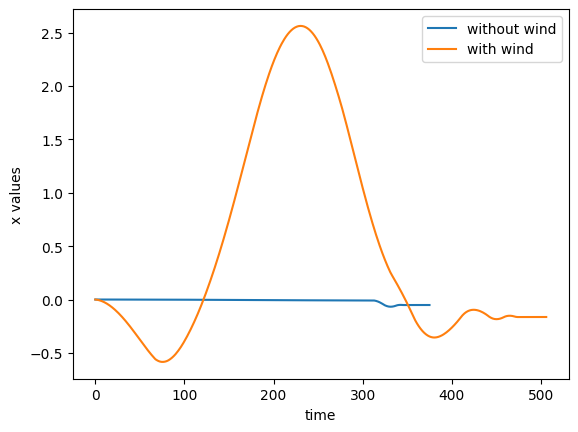

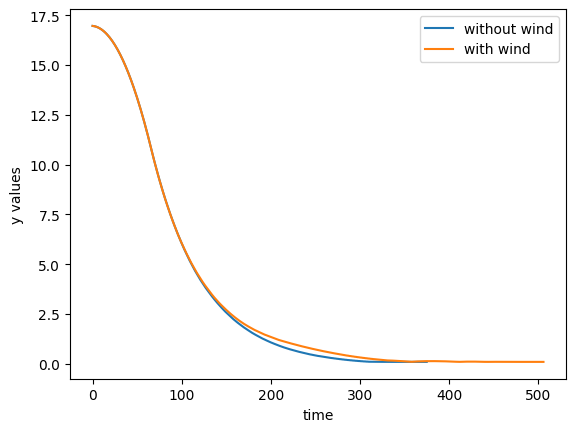

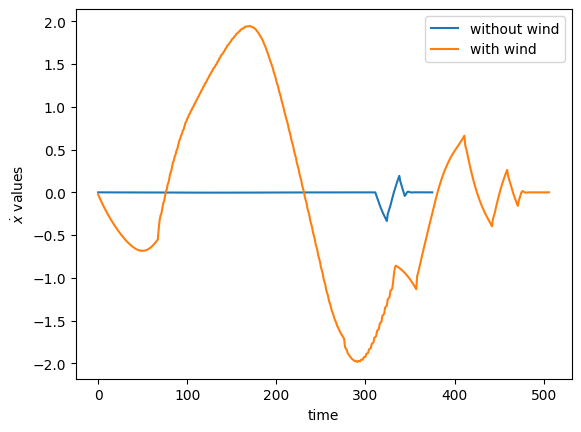

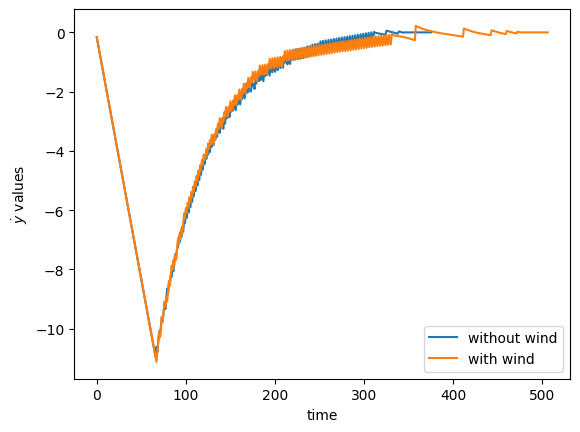

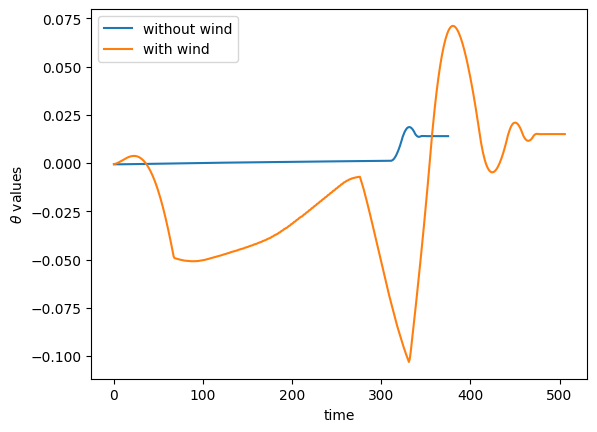

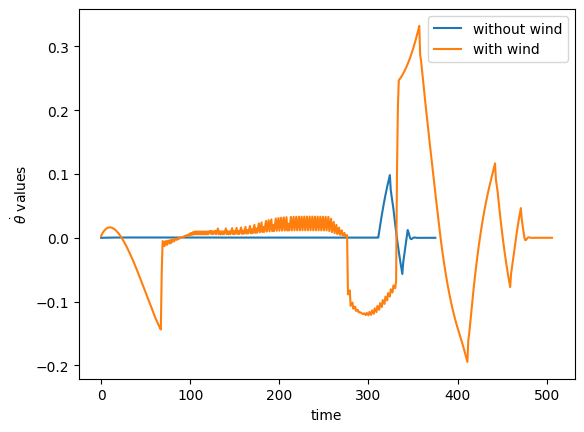

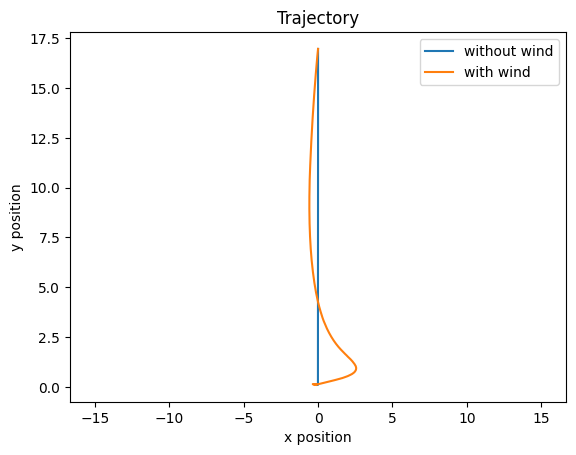

In [17]:
import matplotlib.pyplot as plt
plt.plot(x_vec)
plt.plot(x_vec_w)
plt.xlabel('time')
plt.ylabel('x values')
plt.legend(['without wind', 'with wind'])
plt.show()

plt.plot(y_vec)
plt.plot(y_vec_w)
plt.xlabel('time')
plt.ylabel('y values')
plt.legend(['without wind', 'with wind'])
plt.show()

plt.plot(xdot_vec)
plt.plot(xdot_vec_w)
plt.xlabel('time')
plt.ylabel(r'$\dot{x}$ values')
plt.legend(['without wind', 'with wind'])
plt.show()

plt.plot(ydot_vec)
plt.plot(ydot_vec_w)
plt.xlabel('time')
plt.ylabel(r'$ \dot{y}$ values')
plt.legend(['without wind', 'with wind'])
plt.show()

plt.plot(teta_vec)
plt.plot(teta_vec_w)
plt.xlabel('time')
plt.ylabel(r'$\theta$ values')
plt.legend(['without wind', 'with wind'])
plt.show()

plt.plot(tetadot_vec)
plt.plot(tetadot_vec_w)
plt.xlabel('time')
plt.ylabel(r'$\dot{\theta}$ values')
plt.legend(['without wind', 'with wind'])
plt.show()


plt.plot(x_vec,y_vec)
plt.plot(x_vec_w,y_vec_w)
plt.xlabel('x position')
plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
plt.ylabel('y position')
plt.legend(['without wind', 'with wind'])
plt.title('Trajectory')
plt.show()




## Failure Scenario

It is very unlikely that the rocket starts centered with ideal landing spot and it is likely there they will be wind disturbance when trying to land the rocket. The initial position and angle of the rocket was varied until a failure occured.

In total, 4 cases were analyzed, by shifting the rocket 0.15 to the right, by tilting its inclination by 0.3 to both sides and by disabling and enabling wind.  

In [18]:
args1 = {
    "initial_position": (0.65,0.95, 0.3), # failure
}

args2 = {
    "initial_position": (0.65,0.95, 0.3), # failure
    "enable_wind": True
}

args3 = {
    "initial_position": (0.65,0.95, -0.3), # success
}

args4 = {
    "initial_position": (0.65,0.95, -0.3), # failure
    "enable_wind": True
}

args_vec = [args1, args2, args3, args4]


obs, info = env.reset(seed=0)  # specify a random seed for consistency

X_VEC = []
Y_VEC = []
XDOT_VEC = []
YDOT_VEC = []
TETA_VEC = []
TETADOT_VEC = []



# fe_vec = []
# last_fe = 0
# fs_vec = []
# last_fs = 0
# phi_vec = []
# last_phi = 0
# phi_t_1 = 0

a = 0
for args in args_vec:
  # make environment and wrap video so that we can replay them later
  env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)
  # env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example" + str(a))
  a+=1;
  env.reset()

  x_vec = []
  y_vec = []
  xdot_vec = []
  ydot_vec = []
  teta_vec = []
  tetadot_vec = []
  # simulate
  while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      pid_obs = obs
      pid_obs[0] = obs[0] - landing_position[0]
      pid_obs[1] = obs[1] - landing_position[1]

      x_vec.append(pid_obs[0])
      y_vec.append(pid_obs[1])
      xdot_vec.append(pid_obs[2])
      ydot_vec.append(pid_obs[3])
      teta_vec.append(pid_obs[4])
      tetadot_vec.append(pid_obs[5])

      # get action
      action = np.array(pid.pid_algorithm(pid_obs))
      action = action.clip([0, -1 , -1], [1, 1, 1])  # clip the PID action to the action range

      # last_fe += abs(action[0])
      # fe_vec.append(last_fe)
      # last_fs += abs(action[1])
      # fs_vec_w.append(last_fs)
      # last_phi += abs(action[2] - phi_t_1)
      # phi_t_1 = action[2]
      # phi_vec.append(last_phi)
      # action+=np.random.normal(scale = 0.2,size=action.size)
      # print(action)

      next_obs, rewards, done, _, info = env.step(action)

      # check if simulation ended
      if done:
          break

      # update observation
      obs = next_obs

  env.close()  # video saved at this step

  X_VEC.append(x_vec)
  Y_VEC.append(y_vec)
  XDOT_VEC.append(xdot_vec)
  YDOT_VEC.append(ydot_vec)
  TETA_VEC.append(teta_vec)
  TETADOT_VEC.append(tetadot_vec)


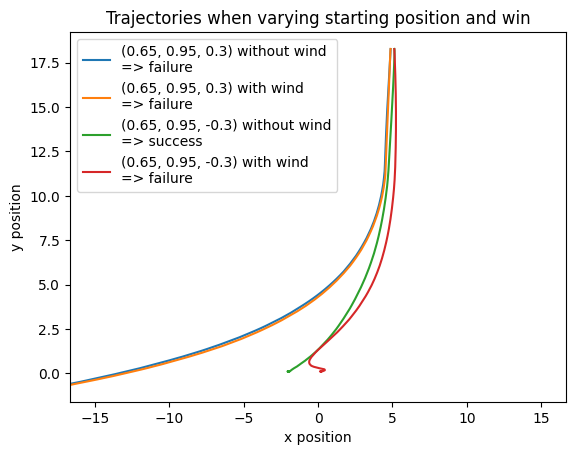

In [19]:
initital_positions = [(0.65,0.95, 0.3), (0.65,0.95, -0.3)]

for ip in range(len(initital_positions)):
  plt.plot(X_VEC[ip*2][1:], Y_VEC[ip*2][1:])
  plt.plot(X_VEC[ip*2+1][1:], Y_VEC[ip*2+1][1:])
plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend([str(initital_positions[0]) + ' without wind\n=> failure', str(initital_positions[0]) + ' with wind\n=> failure',
                str(initital_positions[1]) + ' without wind\n=> success', str(initital_positions[1]) + ' with wind\n=> failure'],loc='upper left')
plt.title('Trajectories when varying starting position and win')
plt.show()


### Video
Failure scenario:
- initial conditions: (0.65, 0.95, 0.3)
- wind enabled

In [20]:
args = {
    "initial_position": (0.65,0.95, 0.3), # failure
    "enable_wind": True
}



obs, info = env.reset(seed=0)  # specify a random seed for consistency

# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="Henrique_DuarteHachmeisterCaraca_PID_Failure_Case")
env.reset()


# simulate
while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]
      # offset so that (0, 0) is at landing position
      pid_obs = obs
      pid_obs[0] = obs[0] - landing_position[0]
      pid_obs[1] = obs[1] - landing_position[1]


      # get action
      action = np.array(pid.pid_algorithm(pid_obs))
      action = action.clip([0, -1 , -1], [1, 1, 1])  # clip the PID action to the action range

      next_obs, rewards, done, _, info = env.step(action)

      # check if simulation ended
      if done:
          break

      # update observation
      obs = next_obs

env.close()  # video saved at this step



/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/Henrique_DuarteHachmeisterCaraca_PID_Failure_Case-episode-0.mp4.
Moviepy - Writing video /content/video/Henrique_DuarteHachmeisterCaraca_PID_Failure_Case-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/Henrique_DuarteHachmeisterCaraca_PID_Failure_Case-episode-0.mp4


In [21]:
show_video(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## My controller

The controller that I chose to implement was a controller with Model Predictive Control (MPC).

The controller computes a new input every 10 frames (i.e. every 0.17 seconds). Depending on the y-distance to the floor, the length of the time window horizon is varied. This was done because, when the rocket is very far from the barge, a large horizon is required just so that it is physically possible for the rocket to reach the floor (even when no thurst is applyed). Using a smaller horizon, when close to the barge, is also helpful when landing, because it makes the process quicker and avoids future wind disturbances. The controller has in total 4 different areas (the areas were actual defined with infinity norm instead of just y-distance, but the general idea is the same). 4 areas were used instead of 2 (close and far to the barge) because the transiction from one to the other needs to be smooth, otherwise the controller would change the input drastically from one frame to the other.

The controller has in total 9 parameters to be tuned: three to define the limits between the four areas, the length of the horizon for each of the four areas, the Q matrix and the R matrix.

The tunning was done experimentally. Initialy the cost of each state was 1 and the cost of each input was also 1. Many simulations were done while tuning each cost. The main focus was on the cost of the states and not on the cost of the inputs as no limitations were posed on the latter; the only change was making it cheaper to use the thrust over the other inputs because the lateral thrust and movement of the nozzle seem to be more limited - there is probably less side propeller then main propeller inside the rocket and quick movements from the nozzle seem to be mechanically expensive.  From my studies, the hardest part in the landing the rocket is peforming the movement in the x-direction while simultaneously keeping it vertical, thus, the states with the highest cost are theta and theta-dot, so that the controller fixes these errors as soon as possible instead of them increasing quickly and the rocket crushing.

Final configuration:
- Q = np.diag([1, 0.1, 0.1, 0.1, 5, 30])
- R = np.diag([0.5, 1, 1])
- length of horizon: 25, 16, 12, 5
- limits of areas: 5, 1, 1.5

In [22]:
import gymnasium as gym

from coco_rocket_lander.env import SystemModel

frames_until_action = 10 #number of frames to be advanced until a new control action is computed

env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args={})

model = SystemModel(env)

# by default, linearize around upright equilibrium with F_E = m*g
model.calculate_linear_system_matrices()

# you are free to change the sampling time as you wish
update = 60//frames_until_action # number of control actions per second
model.discretize_system_matrices(sample_time=1/update)
A, B = model.get_discrete_linear_system_matrices()

print("A:\n", A.round(3), "\n"*2, "B:\n", B.round(3))
print(1/update)

A:
 [[ 1.     0.     0.167  0.    -0.136 -0.008]
 [ 0.     1.     0.     0.167  0.     0.   ]
 [ 0.     0.     1.     0.    -1.635 -0.136]
 [ 0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.167]
 [ 0.     0.     0.     0.     0.     1.   ]] 

 B:
 [[ 0.     0.009 -0.035]
 [ 0.422  0.     0.   ]
 [ 0.     0.106 -0.404]
 [ 5.065  0.     0.   ]
 [ 0.    -0.008 -0.045]
 [ 0.    -0.095 -0.534]]
0.16666666666666666


In [23]:
from cvxpy.reductions.solvers.defines import QP_SOLVERS
import cvxpy as cp
from numpy import linalg as LA

import numpy as np

import coco_rocket_lander

# calculate the gravity compensation, subtract from applied actions
gravity = env.cfg.gravity
mass, inertia = env.get_mass_properties()
gravity_comp_fraction = -gravity * mass / env.cfg.main_engine_thrust

def mpc_algo(x_0, horizon_far, horizon_middle, horizon_close, Q, R, A, B): #returns first input to apply
    if LA.norm(x_0, np.inf) > 5:
      K = horizon_far
    elif LA.norm(x_0, np.inf) > 1:
      K = horizon_middle
    elif LA.norm(x_0, np.inf) > 0.15:
      K = horizon_close
    else:
      # x_0[1]+=0.1
      K = 5

    n_x = 6
    x = cp.Variable((n_x, K + 1))
    n_u = 3
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    x_0 = x_0[:6]

    # x_traj = np.zeros([n_x, K+1])
    # u_traj =  np.zeros([n_u, K])
    # x_traj[:, 0] = x_0[:6]

    for k in range(K):
        cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R)
        constr += [x[:, k + 1] == A @ x[:, k] + B @ (u[:, k]+np.array([-gravity_comp_fraction,0,0])),
                   cp.abs(x[0, k]) <= env.cfg.width/2, cp.abs(x[1, k] - env.cfg.height/2) <= env.cfg.height/2, cp.abs(x[4, k]) <= env.cfg.theta_limit, #cp.abs(x[5, k]) <= 1,
                   cp.abs(u[0, k]-0.5) <= 0.5, cp.abs(u[1, k]) <= 1, cp.abs(u[2, k]) <= 1]
    # sums problem objectives and concatenates constraints.
    # print("here")
    constr += [x[:, K] == 0, x[:, 0] == x_0]
    # print("x_0: ", x_0)
    # print(LA.norm(x_0, np.inf))
    # if LA.norm(x_0, np.inf) > 10:
    #   constr += [cp.norm(x[:, K], 'inf') <= 4, x[:, 0] == x_0]
    # elif LA.norm(x_0, np.inf) > 5:
    #   constr += [cp.norm(x[:, K], 'inf') <= 2, x[:, 0] == x_0]
    # if False:
    #   a = 0
    # else:
    #   constr += [x[:, K] == 0, x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.SCS)
    # problem.solve(verbose=True)

    if problem.status == "infeasible":
        # print("###################")
        print("Problem is infeasible.")
        # print("x_0: ",x_0)
        env.close()
        # print("###################")
        return [0, 0 ,0], True
    # print("feasible")
    # print("x_k = ",x[:, K].value)
    # print("norm: ", cp.norm(x[:, K], 'inf').value)

    # print("Predicted: ", x[:,1].value)

    return u[:,0].value, False

WARNING: the following code is comented out because it takes 6 to execute and it is only helpful to produce the plot before. To see the plot uncomment the following two blocks of code and run them

In [49]:
# X_VEC = []
# Y_VEC = []
# XDOT_VEC = []
# YDOT_VEC = []
# TETA_VEC = []
# TETADOT_VEC = []

# tot_fe_mpc = 0
# tot_fs_mpc = 0
# tot_nozzle_mpc = 0


# initial_positions = [(0.5-0.25,0.95, -0.5), (0.5-0.25,0.95, 0.5), (0.5-0.25,0.95, -0.3), (0.5-0.25,0.95, 0.3),
#                      (0.5+0.25,0.95, -0.5), (0.5+0.25,0.95, 0.5), (0.5+0.25,0.95, -0.3), (0.5+0.25,0.95, 0.3),
#                      (0.5-0.15,0.95, -0.5), (0.5-0.15,0.95, 0.5), (0.5-0.15,0.95, -0.3), (0.5-0.15,0.95, 0.3),
#                      (0.5+0.15,0.95, -0.5), (0.5+0.15,0.95, 0.5), (0.5+0.15,0.95, -0.3), (0.5+0.15,0.95, 0.3)]

# for ip in range(len(initial_positions)):
#   # start the rocket at the center
#   args = {
#       "initial_position": initial_positions[ip],
#       # "initial_position": (0.45,0.95, -0.1),
#       "enable_wind": True
#   }


#   # make environment and wrap video so that we can replay them later
#   env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)


#   obs, info = env.reset(seed=0)  # specify a random seed for consistency

#   Q = np.diag([1, 0.1, 0.1, 0.1, 5, 30])
#   R = np.diag([0.5, 1, 1])

#   x_vec = []
#   y_vec = []
#   xdot_vec = []
#   ydot_vec = []
#   teta_vec = []
#   tetadot_vec = []

#   last_nozzle = 0

#   # simulate
#   counter = 0 #goes back to zero every 3 times
#   while True:
#       landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
#       # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

#       # offset so that (0, 0) is at landing position
#       error = obs.copy()
#       error[0] = obs[0] - landing_position[0]
#       error[1] = obs[1] - landing_position[1]

#       x_vec.append(error[0])
#       y_vec.append(error[1])
#       xdot_vec.append(error[2])
#       ydot_vec.append(error[3])
#       teta_vec.append(error[4])
#       tetadot_vec.append(error[5])


#       # action = [0,0,0]
#       if counter == 0:
#         action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))
#       # print("u: ", action)
#       counter = (counter+1)%frames_until_action

#       # noisy_action = action + np.random.normal(scale=0.01, size=(3,))


#       if error_flag: break


#       tot_fe_mpc += abs(action[0])
#       tot_fs_mpc += abs(action[1])
#       tot_nozzle_mpc += abs(last_nozzle - action[2])
#       last_nozzle = action[2]

#       next_obs, rewards, done, _, info = env.step(action)
#       # print("reward: ",rewards)
#       # if next_obs[-2] and next_obs[-1]:
#       #   print("LANDED")
#       #   break

#       # check if simulation ended
#       if done:
#           # print("landed - ", ip, " - ",initial_positions[ip])
#           break

#       # update observation
#       obs = next_obs

#   env.close()  # video saved at this step

#   X_VEC.append(x_vec)
#   Y_VEC.append(y_vec)
#   XDOT_VEC.append(xdot_vec)
#   YDOT_VEC.append(ydot_vec)
#   TETA_VEC.append(teta_vec)
#   TETADOT_VEC.append(tetadot_vec)


<ipython-input-49-97bc94069d5e>:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))


Problem is infeasible.
Moviepy - Building video /content/video/aaaa0-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa0-episode-0.mp4
Moviepy - Building video /content/video/aaaa1-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa1-episode-0.mp4
Moviepy - Building video /content/video/aaaa2-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa2-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa2-episode-0.mp4
Moviepy - Building video /content/video/aaaa3-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa3-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa3-episode-0.mp4
Moviepy - Building video /content/video/aaaa4-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa4-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa4-episode-0.mp4
Problem is infeasible.
Moviepy - Building video /content/video/aaaa5-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa5-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa5-episode-0.mp4
Moviepy - Building video /content/video/aaaa6-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa6-episode-0.mp4
Moviepy - Building video /content/video/aaaa7-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa7-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa7-episode-0.mp4
Moviepy - Building video /content/video/aaaa8-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa8-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa8-episode-0.mp4
Moviepy - Building video /content/video/aaaa9-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa9-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa9-episode-0.mp4
Moviepy - Building video /content/video/aaaa10-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa10-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa10-episode-0.mp4
Moviepy - Building video /content/video/aaaa11-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa11-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa11-episode-0.mp4
Moviepy - Building video /content/video/aaaa12-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa12-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa12-episode-0.mp4
Moviepy - Building video /content/video/aaaa13-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa13-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa13-episode-0.mp4
Moviepy - Building video /content/video/aaaa14-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa14-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa14-episode-0.mp4
Moviepy - Building video /content/video/aaaa15-episode-0.mp4.
Moviepy - Writing video /content/video/aaaa15-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/aaaa15-episode-0.mp4


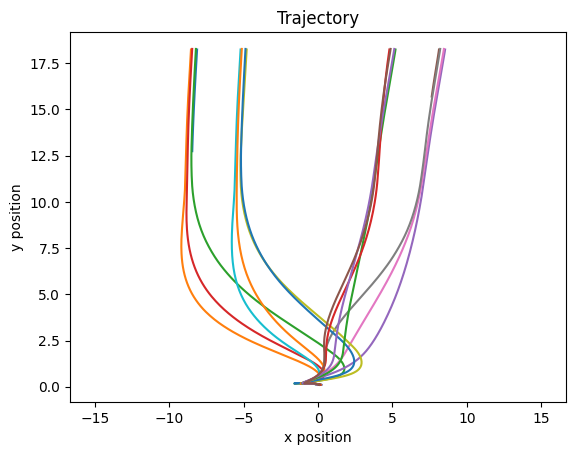

In [50]:
# for ip in range(len(initial_positions)):
#   plt.plot(X_VEC[ip], Y_VEC[ip])
# plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
# plt.xlabel('x position')
# plt.ylabel('y position')
# plt.title('Trajectory')
# plt.show()

In [26]:
# without wind

# start the rocket at the center
args = {}



# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)


obs, info = env.reset(seed=0)  # specify a random seed for consistency

x_vec = []
y_vec = []
xdot_vec = []
ydot_vec = []
teta_vec = []
tetadot_vec = []

fe_vec_mpc = []
last_fe_mpc = 0
fs_vec_mpc = []
last_fs_mpc = 0
phi_vec_mpc = []
last_phi_mpc = 0
phi_t_1_mpc = 0

Q = np.diag([1, 0.1, 0.1, 0.1, 5, 30])
R = np.diag([0.5, 1, 1])

counter = 0
# simulate
while True:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
    # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

    # offset so that (0, 0) is at landing position
    error = obs.copy()
    error[0] = obs[0] - landing_position[0]
    error[1] = obs[1] - landing_position[1]

    x_vec.append(error[0])
    y_vec.append(error[1])
    xdot_vec.append(error[2])
    ydot_vec.append(error[3])
    teta_vec.append(error[4])
    tetadot_vec.append(error[5])

    # get action
    if counter == 0:
      action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))
    # print("u: ", action)
    counter = (counter+1)%frames_until_action

    if error_flag: break

    last_fe_mpc += abs(action[0])
    fe_vec_mpc.append(last_fe_mpc)
    last_fs_mpc += abs(action[1])
    fs_vec_mpc.append(last_fs_mpc)
    last_phi_mpc += abs(action[2] - phi_t_1_mpc)
    phi_t_1_mpc = action[2]
    phi_vec_mpc.append(last_phi_mpc)

    # action+=np.random.normal(scale = 0.2,size=action.size)
    # print(action)

    next_obs, rewards, done, _, info = env.step(action)

    # check if simulation ended
    if done:
        break

    # update observation
    obs = next_obs

env.close()  # video saved at this step

<ipython-input-26-0f0a33cbc7e4>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))


In [27]:
# with wind MPC

# start the rocket at the center
args = {"enable_wind":True}



# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1000)


obs, info = env.reset(seed=0)  # specify a random seed for consistency


fe_vec_w_mpc = []
last_fe_w_mpc = 0
fs_vec_w_mpc = []
last_fs_w_mpc = 0
phi_vec_w_mpc = []
last_phi_w_mpc = 0
phi_t_1_w_mpc = 0

# simulate
while True:
    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
    # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

    # offset so that (0, 0) is at landing position
    error = obs.copy()
    error[0] = obs[0] - landing_position[0]
    error[1] = obs[1] - landing_position[1]

    # get action
    if counter == 0:
      action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))
    # print("u: ", action)
    counter = (counter+1)%frames_until_action

    if error_flag: break

    last_fe_w_mpc += abs(action[0])
    fe_vec_w_mpc.append(last_fe_w_mpc)
    last_fs_w_mpc += abs(action[1])
    fs_vec_w_mpc.append(last_fs_w_mpc)
    last_phi_w_mpc += abs(action[2] - phi_t_1_w_mpc)
    phi_t_1_w_mpc = action[2]
    phi_vec_w_mpc.append(last_phi_w_mpc)

    # action+=np.random.normal(scale = 0.2,size=action.size)
    # print(action)

    next_obs, rewards, done, _, info = env.step(action)

    # check if simulation ended
    if done:
        break

    # update observation
    obs = next_obs

env.close()  # video saved at this step

<ipython-input-27-4261aab48d3c>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))


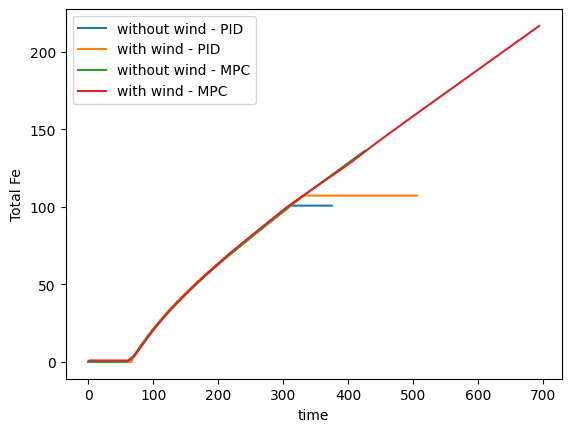

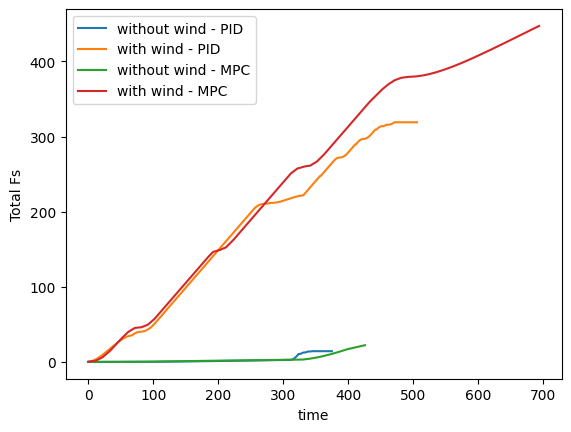

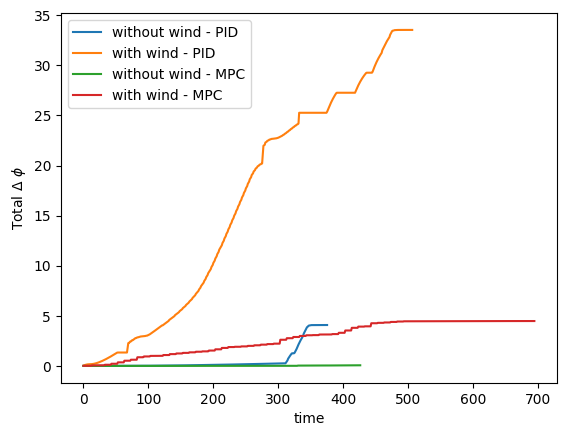

In [28]:
plt.plot(fe_vec_pid)
plt.plot(fe_vec_w_pid)
plt.plot(fe_vec_mpc)
plt.plot(fe_vec_w_mpc)
plt.xlabel('time')
plt.ylabel('Total Fe')
plt.legend(['without wind - PID', 'with wind - PID','without wind - MPC', 'with wind - MPC'])
plt.show()

plt.plot(fs_vec_pid)
plt.plot(fs_vec_w_pid)
plt.plot(fs_vec_mpc)
plt.plot(fs_vec_w_mpc)
plt.xlabel('time')
plt.ylabel('Total Fs')
plt.legend(['without wind - PID', 'with wind - PID','without wind - MPC', 'with wind - MPC'])
plt.show()

plt.plot(phi_vec_pid)
plt.plot(phi_vec_w_pid)
plt.plot(phi_vec_mpc)
plt.plot(phi_vec_w_mpc)
plt.xlabel('time')
plt.ylabel(r'Total $\Delta$ $\phi$')
plt.legend(['without wind - PID', 'with wind - PID','without wind - MPC', 'with wind - MPC'])
plt.show()

### Video

In [29]:
args = {
    "initial_position": (0.65,0.95, 0.3), # failure
    "enable_wind": True
}




# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="Henrique_DuarteHachmeisterCaraca_Controller_Demonstrartion")

# obs, info = env.reset(seed=0)  # specify a random seed for consistency
obs, info = env.reset(seed=0)
Q = np.diag([1, 0.1, 0.1, 0.1, 5, 30])
R = np.diag([0.5, 1, 1])


# simulate
counter = 0 #goes back to zero every 3 times
while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      error = obs.copy()
      error[0] = obs[0] - landing_position[0]
      error[1] = obs[1] - landing_position[1]


      # action = [0,0,0]
      if counter == 0:
        action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))
      # print("u: ", action)
      counter = (counter+1)%frames_until_action

      # noisy_action = action + np.random.normal(scale=0.01, size=(3,))


      if error_flag: break


      next_obs, rewards, done, _, info = env.step(action)
      # print("reward: ",rewards)
      # if next_obs[-2] and next_obs[-1]:
      #   print("LANDED")
      #   break

      # check if simulation ended
      if done:
          break

      # update observation
      obs = next_obs

env.close()  # video saved at this step


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
<ipython-input-29-02375ce5f94f>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  action, error_flag = np.array(mpc_algo(error, 25, 16, 12, Q,R,A,B))


Moviepy - Building video /content/video/Henrique_DuarteHachmeisterCaraca_Controller_Demonstrartion-episode-0.mp4.
Moviepy - Writing video /content/video/Henrique_DuarteHachmeisterCaraca_Controller_Demonstrartion-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/Henrique_DuarteHachmeisterCaraca_Controller_Demonstrartion-episode-0.mp4


In [30]:
show_video(0)

## Model free solution

For the case where there is no model information, I opted to use Reinforcement Learning (RL).

I first decided to use SARSA, but this proved extremely unsuccessful as every iteration was very short and most of the state was left unexplored impacting the convergence of the Q-matrix.

Afterwards, I used Reinforcement Learning with a Q table but the results were also unsatisfatory as the best accuracy that I got as around 2%. The problem here was that there are 6 state-variable with 3 inputs which require a huge Q matrix. I ended having to reduce a lot the degrees of freedom of the input and discretize a lot the state-variables and that resulted in bad performance.

Lastly, I used Reinforcemet Learning with Proximal Policy Optimization using a Multi Layer Perceptron policy, which resulted in much better performance. This was implemented with the help of the StableBaselines3 library.

The code for the training was commented out since it would take a long time.

### Q-table learning

In [31]:
def fit(limits, value):
  for n in range(len(limits)):
    if limits[n]>value:
      return n
  return n+1

# Q_matrix
# x_dis = ([a/3/9 for a in range(0,int(env.cfg.width*3*9),100)]+[env.cfg.width])[1:-1]
# x_dis = [8.333, 12.5, 16.666, 20.833, 25]
# y_dis = [3.333, 6.667, 13.333, 20]
x_dis = [env.cfg.width/10*a for a in range(1,10)]
y_dis = [env.cfg.height/5*a for a in range(1,5)]
teta_dis = [a*7*3.1416/180 for a in range(-4,5)]
state_dis_len = (len(x_dis)+1)*(len(y_dis)+1)*(len(teta_dis)+1)
print(state_dis_len)
print(x_dis)
print(y_dis)
print(teta_dis)
x_dot_dis = [a/5 for a in range(-9,10,2)]
y_dot_dis = [a/5 for a in range(-9,10,2)]
teta_dot_dis = [a/5 for a in range(-9,10)]
print(x_dot_dis)
print(y_dot_dis)
print(teta_dot_dis)


Fe_dis = [0.1, 0.2, 0.8, 1]
Fs_dis = [-1, -0.2,0, 0.2,  1]
gamma_dis = [-1, -0.3, 0, 0.3, 1]
input_dis = []
for a in Fe_dis:
  for b in Fs_dis:
    for c in gamma_dis:
      input_dis.append([a,b,c])
print(len(input_dis), input_dis)

def get_state_index(x,y,x_,y_,t,t_):
  x_ind = fit(x_dis,x)
  y_ind = fit(y_dis,y)
  x_ind_ = fit(x_dot_dis,x)
  y_ind_ = fit(y_dot_dis,y)
  teta_ind = fit(teta_dis,t)
  teta_ind_ = fit(teta_dot_dis,t)
  return x_ind*((len(y_dis)+1)*(len(x_dot_dis)+1)*(len(y_dot_dis)+1)*(len(teta_dis)+1)*(len(teta_dot_dis)+1)) + y_ind*((len(x_dot_dis)+1)*(len(y_dot_dis)+1)*(len(teta_dis)+1)*(len(teta_dot_dis)+1)) +  y_ind_*((len(y_dot_dis)+1)*(len(teta_dis)+1)*(len(teta_dot_dis)+1)) + x_ind_*((len(teta_dis)+1)*(len(teta_dot_dis)+1)) + teta_ind*(len(teta_dot_dis)+1) + teta_ind_



500
[3.3333333333333335, 6.666666666666667, 10.0, 13.333333333333334, 16.666666666666668, 20.0, 23.333333333333336, 26.666666666666668, 30.0]
[5.333333333333334, 10.666666666666668, 16.0, 21.333333333333336]
[-0.4886933333333333, -0.36652, -0.24434666666666666, -0.12217333333333333, 0.0, 0.12217333333333333, 0.24434666666666666, 0.36652, 0.4886933333333333]
[-1.8, -1.4, -1.0, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8]
[-1.8, -1.4, -1.0, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8]
[-1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
100 [[0.1, -1, -1], [0.1, -1, -0.3], [0.1, -1, 0], [0.1, -1, 0.3], [0.1, -1, 1], [0.1, -0.2, -1], [0.1, -0.2, -0.3], [0.1, -0.2, 0], [0.1, -0.2, 0.3], [0.1, -0.2, 1], [0.1, 0, -1], [0.1, 0, -0.3], [0.1, 0, 0], [0.1, 0, 0.3], [0.1, 0, 1], [0.1, 0.2, -1], [0.1, 0.2, -0.3], [0.1, 0.2, 0], [0.1, 0.2, 0.3], [0.1, 0.2, 1], [0.1, 1, -1], [0.1, 1, -0.3], [0.1, 1, 0], [0.1, 1, 0.3], [0.1, 1, 1], [0.2, -1, -1], [0.2, -1, -0.3], [

In [32]:
import numpy as np
from random import randrange

class Learner:
  def __init__(self, x_dis, y_dis, teta_dis, x_dot_dis, y_dot_dis, teta_dot_dis, input_dis, Q_init_file = None):
    self.state_dis_len = (len(x_dis)+1)*(len(y_dis)+1)*(len(teta_dis)+1)*(len(x_dot_dis)+1)*(len(y_dot_dis)+1)*(len(teta_dot_dis)+1)
    self.x_dis = x_dis
    self.y_dis = y_dis
    self.t_dis = teta_dis
    self.input_dis = input_dis

    self.alpha = 0.001
    self.gamma = 0.95

    # self.policy = np.ones((self.state_dis_len, len(self.input_dis)))*1/(len(self.input_dis)*self.state_dis_len)
    self.policy = np.ones((self.state_dis_len, len(self.input_dis)))*1/(len(self.input_dis)*self.state_dis_len)
    if not Q_init_file:
      self.Q = np.random.uniform(low = -2, high=0, size = (self.state_dis_len, len(self.input_dis)))#-np.inf
    else:
      self.Q = np.load(Q_init_file)

    # self.eps = 0.05

  def find_best_policy(self, state):
    cand = np.zeros(len(self.input_dis))
    for u in range(len(self.input_dis)):
      cand[u] = self.Q[state,u]
    return np.max(cand), np.argmax(cand) # since it is a reward, we maximize

  def greedy_update(self):  #update policy
    for s in range(self.state_dis_len):
      self.policy[s] = 0#self.e/len(self.input_dis)
      val, index = self.find_best_policy(s)
      self.policy[s,index] = 1#-self.e

  def get_action(self,obs,eps):
    # print(obs)
    state = get_state_index(*obs)
    if np.random.rand() <= eps:
      return randrange(len(self.input_dis))
    else:
      return np.argmax(self.Q[state,:])


  def update(self, state, input, rew, next_state):
    self.Q[state, input] += self.alpha*(rew + self.gamma*np.max(self.Q[next_state,:]) - self.Q[state, input])

  def save_Q(self, filename):
    np.save(filename, self.Q)

  def print_Q(self): # for debugging
    print(self.Q)

In [33]:
AI = Learner( x_dis, y_dis, teta_dis, x_dot_dis, y_dot_dis, teta_dot_dis, input_dis)

######################
# Parameters
number_iterations = 25000
n_experiments = 10
exploration_eps = 1 # eps for the greedy strategy

x_rand = [0.35, 0,42, 0,5 , 0.58, 0.65]
y_rand = 0.95
teta_rand = [-0.5,-0.3,0,0.3,0.5]

tot_landed = 0
for t in range(number_iterations):
  # make environment and wrap video so that we can replay them later
  args={
      # "initial_position": (0.5,0.65, 0)
      # "initial_position": (x_rand[randrange(len(x_rand))],y_rand, teta_rand[randrange(len(teta_rand))])
      "initial_position": (randrange(30,70)/100,randrange(85,95)/100, randrange(-50,50)/100)
  }
  env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=500)

  if t%1000 == 0:
    print("\nTOT_LANDED: "+str(tot_landed)+"\n")
    tot_landed = 0
    env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example"+"0"*(6-len(str(t)))+str(t))

  # specify the target
  target_x = env.cfg.width / 2
  target_y = env.cfg.height / 2

  obs, info = env.reset(seed=0)  # specify a random seed for consistency



# for t in range(number_iterations):
  # obs, info = env.reset(seed=0)
  obs, info = env.reset()
  while True:

    action_index = AI.get_action(obs[:6],exploration_eps)
    # print(action_index, end = " - ")

    fe_index = action_index//(len(Fs_dis)*len(gamma_dis))
    fs_index = (action_index-fe_index*(len(Fs_dis)*len(gamma_dis)))//(len(gamma_dis))
    gamma_index =  (action_index-fe_index*(len(Fs_dis)*len(gamma_dis))-fs_index*(len(gamma_dis)))
    # print(action_index, fe_index, fs_index, gamma_index)
    action = [Fe_dis[fe_index], Fs_dis[fs_index], gamma_dis[gamma_index]]

    next_obs, rewards, done, _, info = env.step(action)

    # error = next_obs[2:6].copy()
    # error[2:4]/=10
    # print(error)
    # if rewards>0: rewards /= (1+LA.norm(error, np.inf))
    # if rewards>0: rewards /= (1+abs(next_obs[3]))
    # print(rewards)
    if next_obs[-2] and next_obs[-1] and rewards>0:
      print("LANDED: ", t, "- reward: ",rewards)
      tot_landed+=1
      break
    AI.update(get_state_index(*obs[:6]), action_index, rewards,get_state_index(*next_obs[:6]) )

    # check if simulation ended
    if done:
        break



    # update observation
    obs = next_obs



  # print("\n", AI.Q.sum())
  # print(np.where(AI.Q != 0))

  # exploration_eps*=.9999
  exploration_eps = min(0.05 , exploration_eps*0.999)

######################

  env.close()  # video saved at this step

### PPO

In [34]:
# learning without wind
# env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args={"random_initial_position": True},max_episode_steps=600)

# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=10_000_000)

In [35]:
# learning with wind
# env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args={"random_initial_position": True, "enable_wind": True},max_episode_steps=600)

# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=10_000_000)

In [36]:
# model.save("ppo_rocketlander")

In [37]:
# # continuing training if wanted
# model.learn(total_timesteps=10_000_000, reset_num_timesteps=False)

In [38]:
# final model for the learning wihout wind
!wget --no-check-certificate https://github.com/HCaraca/CoCo/raw/main/ppo_rocketlander_R102_good.zip

--2023-07-07 17:10:31--  https://github.com/HCaraca/CoCo/raw/main/ppo_rocketlander_R102_good.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HCaraca/CoCo/main/ppo_rocketlander_R102_good.zip [following]
--2023-07-07 17:10:32--  https://raw.githubusercontent.com/HCaraca/CoCo/main/ppo_rocketlander_R102_good.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147041 (144K) [application/zip]
Saving to: ‘ppo_rocketlander_R102_good.zip’

ppo_rocketlander_R1 100%[===================>] 143.59K  --.-KB/s    in 0.03s   

2023-07-07 17:10:32 (5.30 MB/s) - ‘ppo_rocketlander_R102_good.zip’ saved [147041

In [39]:
# final model for the learning wih wind
!wget --no-check-certificate https://github.com/HCaraca/CoCo/raw/main/ppo_rocketlander_W55_good.zip

--2023-07-07 17:10:32--  https://github.com/HCaraca/CoCo/raw/main/ppo_rocketlander_W55_good.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HCaraca/CoCo/main/ppo_rocketlander_W55_good.zip [following]
--2023-07-07 17:10:32--  https://raw.githubusercontent.com/HCaraca/CoCo/main/ppo_rocketlander_W55_good.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146587 (143K) [application/zip]
Saving to: ‘ppo_rocketlander_W55_good.zip’

ppo_rocketlander_W5 100%[===================>] 143.15K  --.-KB/s    in 0.03s   

2023-07-07 17:10:33 (5.28 MB/s) - ‘ppo_rocketlander_W55_good.zip’ saved [146587/1465

In [40]:
import coco_rocket_lander
import gymnasium as gym


X_VEC_RL = []
Y_VEC_RL = []
XDOT_VEC_RL = []
YDOT_VEC_RL = []
TETA_VEC_RL = []
TETADOT_VEC_RL = []


initial_positions = [(0.5-0.25,0.95, -0.5), (0.5-0.25,0.95, 0.5), (0.5-0.25,0.95, -0.3), (0.5-0.25,0.95, 0.3),
                     (0.5+0.25,0.95, -0.5), (0.5+0.25,0.95, 0.5), (0.5+0.25,0.95, -0.3), (0.5+0.25,0.95, 0.3),
                     (0.5-0.15,0.95, -0.5), (0.5-0.15,0.95, 0.5), (0.5-0.15,0.95, -0.3), (0.5-0.15,0.95, 0.3),
                     (0.5+0.15,0.95, -0.5), (0.5+0.15,0.95, 0.5), (0.5+0.15,0.95, -0.3), (0.5+0.15,0.95, 0.3)]

tot_landed = 0
for ip in range(len(initial_positions)):
  # start the rocket at the center
  args = {
      "initial_position": initial_positions[ip],
      # "enable_wind": True
  }


  # make environment and wrap video so that we can replay them later
  env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)
  # env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example")
  model = PPO.load("ppo_rocketlander_R102_good",env)


  # obs, info = env.reset(seed=0)  # specify a random seed for consistency
  obs, info = env.reset(seed=0)


  x_vec_rl = []
  y_vec_rl = []
  xdot_vec_rl = []
  ydot_vec_rl = []
  teta_vec_rl = []
  tetadot_vec_rl = []


  # simulate
  counter = 0 #goes back to zero every 3 times
  while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      error = obs.copy()
      error[0] = obs[0] - landing_position[0]
      error[1] = obs[1] - landing_position[1]

      x_vec_rl.append(error[0])
      y_vec_rl.append(error[1])
      xdot_vec_rl.append(error[2])
      ydot_vec_rl.append(error[3])
      teta_vec_rl.append(error[4])
      tetadot_vec_rl.append(error[5])


      action, _states = model.predict(obs)

      action =[a for a in action]

      next_obs, rewards, done, _, info = env.step(action)
      # print("reward: ",rewards)
      # if next_obs[-2] and next_obs[-1]:
      #   print("landed - ", ip, " - ",initial_positions[ip])
      #   break

      # check if simulation ended
      if done:
        if next_obs[-2] and next_obs[-1]:
          print("landed - ", ip, " - ",initial_positions[ip])
          tot_landed+=1
        break

      # update observation
      obs = next_obs

  env.close()  # video saved at this step

  X_VEC_RL.append(x_vec_rl)
  Y_VEC_RL.append(y_vec_rl)
  XDOT_VEC_RL.append(xdot_vec_rl)
  YDOT_VEC_RL.append(ydot_vec_rl)
  TETA_VEC_RL.append(teta_vec_rl)
  TETADOT_VEC_RL.append(tetadot_vec_rl)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  0  -  (0.25, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  1  -  (0.25, 0.95, 0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  2  -  (0.25, 0.95, -0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  3  -  (0.25, 0.95, 0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  4  -  (0.75, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  5  -  (0.75, 0.95, 0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  6  -  (0.75, 0.95, -0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  7  -  (0.75, 0.95, 0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  8  -  (0.35, 0.95, -0

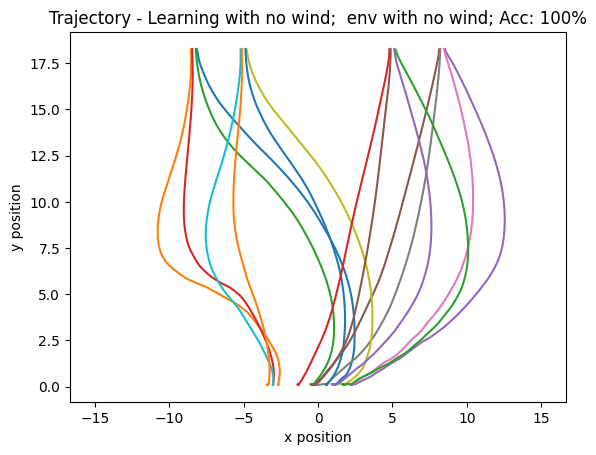

In [41]:
import matplotlib.pyplot as plt
for ip in range(len(initial_positions)):
  plt.plot(X_VEC_RL[ip], Y_VEC_RL[ip])
plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectory - Learning with no wind;  env with no wind; Acc: '+ str(int(tot_landed/len(initial_positions)*100))+'%')
plt.show()

In [42]:
import coco_rocket_lander
import gymnasium as gym


X_VEC_RL = []
Y_VEC_RL = []
XDOT_VEC_RL = []
YDOT_VEC_RL = []
TETA_VEC_RL = []
TETADOT_VEC_RL = []
tot_landed = 0

tot_landed = 0
tot_fe_rl = 0
tot_fs_rl = 0
tot_nozzle_rl = 0


initial_positions = [(0.5-0.25,0.95, -0.5), (0.5-0.25,0.95, 0.5), (0.5-0.25,0.95, -0.3), (0.5-0.25,0.95, 0.3),
                     (0.5+0.25,0.95, -0.5), (0.5+0.25,0.95, 0.5), (0.5+0.25,0.95, -0.3), (0.5+0.25,0.95, 0.3),
                     (0.5-0.15,0.95, -0.5), (0.5-0.15,0.95, 0.5), (0.5-0.15,0.95, -0.3), (0.5-0.15,0.95, 0.3),
                     (0.5+0.15,0.95, -0.5), (0.5+0.15,0.95, 0.5), (0.5+0.15,0.95, -0.3), (0.5+0.15,0.95, 0.3)]

for ip in range(len(initial_positions)):
  # start the rocket at the center
  args = {
      "initial_position": initial_positions[ip],
      "enable_wind": True
  }


  # make environment and wrap video so that we can replay them later
  env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)
  # env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example")
  model = PPO.load("ppo_rocketlander_R102_good",env)


  # obs, info = env.reset(seed=0)  # specify a random seed for consistency
  obs, info = env.reset(seed=0)


  x_vec_rl = []
  y_vec_rl = []
  xdot_vec_rl = []
  ydot_vec_rl = []
  teta_vec_rl = []
  tetadot_vec_rl = []

  last_nozzle = 0
  tmp_fe = 0
  tmp_fs = 0
  tmp_nozzle = 0

  # simulate
  counter = 0 #goes back to zero every 3 times
  while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      error = obs.copy()
      error[0] = obs[0] - landing_position[0]
      error[1] = obs[1] - landing_position[1]

      x_vec_rl.append(error[0])
      y_vec_rl.append(error[1])
      xdot_vec_rl.append(error[2])
      ydot_vec_rl.append(error[3])
      teta_vec_rl.append(error[4])
      tetadot_vec_rl.append(error[5])


      action, _states = model.predict(obs)

      action =[a for a in action]

      tmp_fe += abs(action[0])
      tmp_fs += abs(action[1])
      tmp_nozzle += abs(last_nozzle - action[2])
      last_nozzle = action[2]

      next_obs, rewards, done, _, info = env.step(action)
      # print("reward: ",rewards)
      # if next_obs[-2] and next_obs[-1]:
      #   print("landed - ", ip, " - ",initial_positions[ip])
      #   break

      # check if simulation ended
      if done:
        if next_obs[-2] and next_obs[-1]:
          print("landed - ", ip, " - ",initial_positions[ip])
          tot_landed+=1
          tot_fe_rl += tmp_fe
          tot_fs_rl += tmp_fs
          tot_nozzle_rl += tmp_nozzle
        break

      # update observation
      obs = next_obs

  env.close()  # video saved at this step

  X_VEC_RL.append(x_vec_rl)
  Y_VEC_RL.append(y_vec_rl)
  XDOT_VEC_RL.append(xdot_vec_rl)
  YDOT_VEC_RL.append(ydot_vec_rl)
  TETA_VEC_RL.append(teta_vec_rl)
  TETADOT_VEC_RL.append(tetadot_vec_rl)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  0  -  (0.25, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  1  -  (0.25, 0.95, 0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  4  -  (0.75, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  5  -  (0.75, 0.95, 0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  6  -  (0.75, 0.95, -0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  7  -  (0.75, 0.95, 0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  9  -  (0.35, 

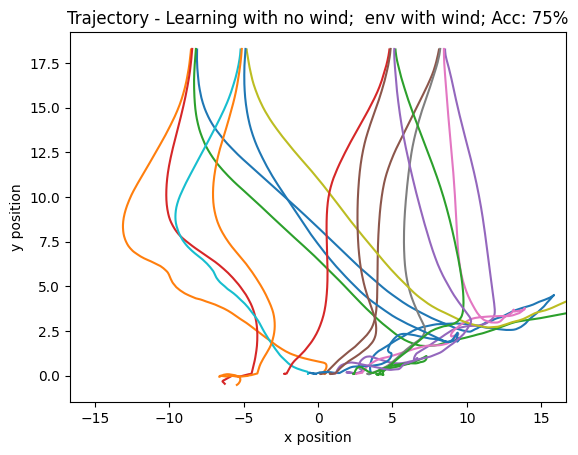

In [43]:
import matplotlib.pyplot as plt
for ip in range(len(initial_positions)):
  plt.plot(X_VEC_RL[ip], Y_VEC_RL[ip])
plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectory - Learning with no wind;  env with wind; Acc: '+ str(int(tot_landed/len(initial_positions)*100))+'%')
plt.show()

In [44]:
import coco_rocket_lander
import gymnasium as gym


X_VEC_RL_w = []
Y_VEC_RL_w = []
XDOT_VEC_RL_w = []
YDOT_VEC_RL_w = []
TETA_VEC_RL_w = []
TETADOT_VEC_RL_w = []
tot_landed_w = 0

tot_fe_rlw = 0
tot_fs_rlw = 0
tot_nozzle_rlw = 0

initial_positions = [(0.5-0.25,0.95, -0.5), (0.5-0.25,0.95, 0.5), (0.5-0.25,0.95, -0.3), (0.5-0.25,0.95, 0.3),
                     (0.5+0.25,0.95, -0.5), (0.5+0.25,0.95, 0.5), (0.5+0.25,0.95, -0.3), (0.5+0.25,0.95, 0.3),
                     (0.5-0.15,0.95, -0.5), (0.5-0.15,0.95, 0.5), (0.5-0.15,0.95, -0.3), (0.5-0.15,0.95, 0.3),
                     (0.5+0.15,0.95, -0.5), (0.5+0.15,0.95, 0.5), (0.5+0.15,0.95, -0.3), (0.5+0.15,0.95, 0.3)]

for ip in range(len(initial_positions)):
  # start the rocket at the center
  args = {
      "initial_position": initial_positions[ip],
      "enable_wind": True
  }


  # make environment and wrap video so that we can replay them later
  env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)
  # env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="pid_example")
  model = PPO.load("ppo_rocketlander_W55_good",env)


  # obs, info = env.reset(seed=0)  # specify a random seed for consistency
  obs, info = env.reset(seed=0)


  x_vec_rl_w = []
  y_vec_rl_w = []
  xdot_vec_rl_w = []
  ydot_vec_rl_w = []
  teta_vec_rl_w = []
  tetadot_vec_rl_w = []

  last_nozzle = 0
  tmp_fe = 0
  tmp_fs = 0
  tmp_nozzle = 0

  # simulate
  counter = 0 #goes back to zero every 3 times
  while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      error = obs.copy()
      error[0] = obs[0] - landing_position[0]
      error[1] = obs[1] - landing_position[1]

      x_vec_rl_w.append(error[0])
      y_vec_rl_w.append(error[1])
      xdot_vec_rl_w.append(error[2])
      ydot_vec_rl_w.append(error[3])
      teta_vec_rl_w.append(error[4])
      tetadot_vec_rl_w.append(error[5])


      action, _states = model.predict(obs)

      action =[a for a in action]

      tmp_fe += abs(action[0])
      tmp_fs += abs(action[1])
      tmp_nozzle += abs(last_nozzle - action[2])
      last_nozzle = action[2]

      next_obs, rewards, done, _, info = env.step(action)
      # print("reward: ",rewards)
      # if next_obs[-2] and next_obs[-1]:
      #   print("LANDED")
      #   break

      # check if simulation ended
      if done:
        if next_obs[-2] and next_obs[-1]:
          print("landed - ", ip, " - ",initial_positions[ip])
          tot_landed_w+=1
          tot_fe_rlw += tmp_fe
          tot_fs_rlw += tmp_fs
          tot_nozzle_rlw += tmp_nozzle
        break

      # update observation
      obs = next_obs

  env.close()  # video saved at this step

  X_VEC_RL_w.append(x_vec_rl_w)
  Y_VEC_RL_w.append(y_vec_rl_w)
  XDOT_VEC_RL_w.append(xdot_vec_rl_w)
  YDOT_VEC_RL_w.append(ydot_vec_rl_w)
  TETA_VEC_RL_w.append(teta_vec_rl_w)
  TETADOT_VEC_RL_w.append(tetadot_vec_rl_w)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  2  -  (0.25, 0.95, -0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  4  -  (0.75, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  5  -  (0.75, 0.95, 0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  6  -  (0.75, 0.95, -0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  7  -  (0.75, 0.95, 0.3)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
landed -  8  -  (0.35, 0.95, -0.5)
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with 

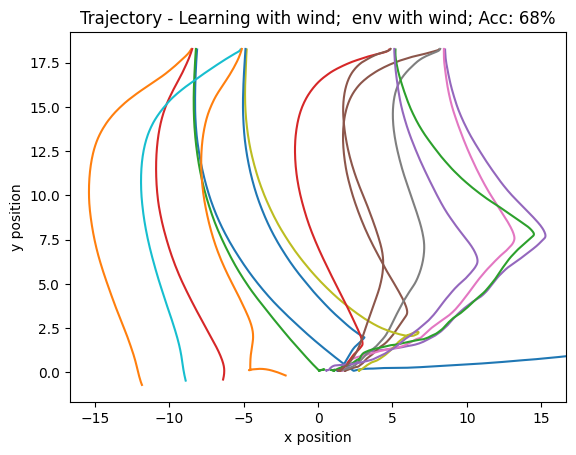

In [45]:
import matplotlib.pyplot as plt
for ip in range(len(initial_positions)):
  plt.plot(X_VEC_RL_w[ip], Y_VEC_RL_w[ip])
plt.xlim(-env.cfg.width / 2, env.cfg.width / 2)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectory - Learning with wind;  env with wind; Acc: '+ str(int(tot_landed_w/len(initial_positions)*100))+'%')
plt.show()

WARNING: the following block of code is also commented out because relies on the previous code that was also commented out

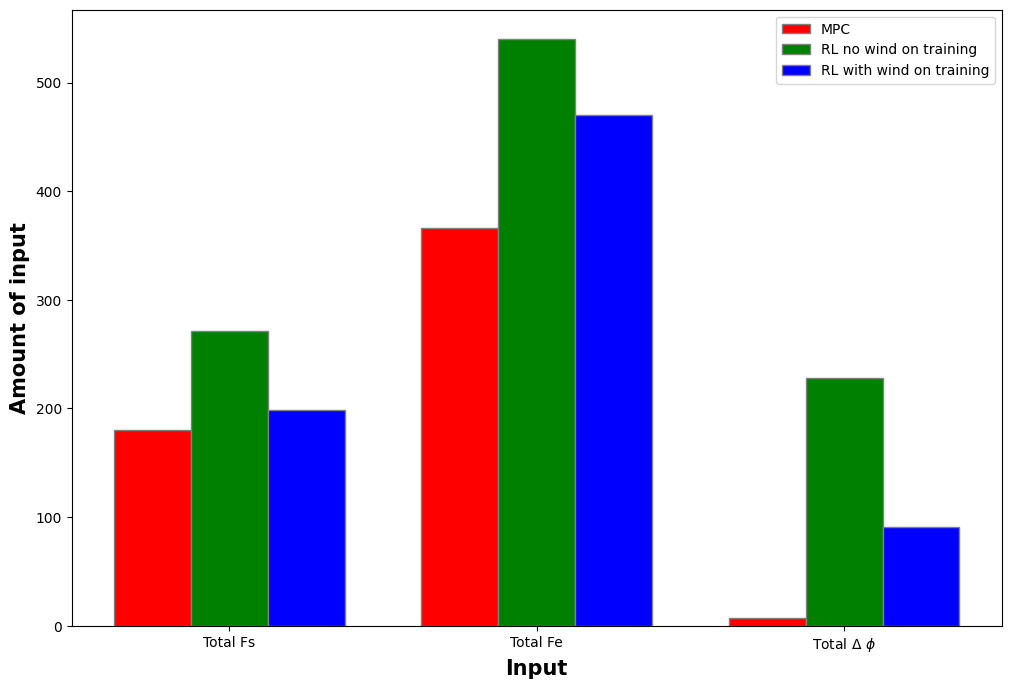

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt

# # set width of bar
# barWidth = 0.25
# fig = plt.subplots(figsize =(12, 8))


# # set height of bar
# MPC = [tot_fe_mpc/16, tot_fs_mpc/16, tot_nozzle_mpc/16]
# RL = [tot_fe_rl/tot_landed, tot_fs_rl/tot_landed, tot_nozzle_rl/tot_landed]
# RLW = [tot_fe_rlw/tot_landed_w, tot_fs_rlw/tot_landed_w, tot_nozzle_rlw/tot_landed_w]


# # Set position of bar on X axis
# br1 = np.arange(len(MPC))
# br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]

# # Make the plot
# plt.bar(br1, MPC, color ='r', width = barWidth,
#         edgecolor ='grey', label ='MPC')
# plt.bar(br2, RL, color ='g', width = barWidth,
#         edgecolor ='grey', label ='RL no wind on training')
# plt.bar(br3, RLW, color ='b', width = barWidth,
#         edgecolor ='grey', label ='RL with wind on training')

# # Adding Xticks
# plt.xlabel('Input', fontweight ='bold', fontsize = 15)
# plt.ylabel('Amount of input', fontweight ='bold', fontsize = 15)
# plt.xticks([r + barWidth for r in range(len(MPC))],
#         ['Total Fs', 'Total Fe', r'Total $\Delta$ $\phi$'])

# plt.legend()
# plt.show()

### Video

Using Reinforcement Learning model that was learned without wind (but tested with wind)

In [47]:

args = {
    "initial_position": (0.65, 0.95, 0.3),
    "enable_wind": True
}


# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args, max_episode_steps=1200)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="Henrique_DuarteHachmeisterCaraca_Model_Free")
model = PPO.load("ppo_rocketlander_R102_good",env)


# obs, info = env.reset(seed=0)  # specify a random seed for consistency
obs, info = env.reset(seed=0)

# simulate
counter = 0 #goes back to zero every 3 times
while True:
      landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
      # landing_position = (target_x, target_y) # (x, y, theta) in [m, m, radians]

      # offset so that (0, 0) is at landing position
      error = obs.copy()
      error[0] = obs[0] - landing_position[0]
      error[1] = obs[1] - landing_position[1]

      x_vec_rl.append(error[0])
      y_vec_rl.append(error[1])
      xdot_vec_rl.append(error[2])
      ydot_vec_rl.append(error[3])
      teta_vec_rl.append(error[4])
      tetadot_vec_rl.append(error[5])


      action, _states = model.predict(obs)

      action =[a for a in action]

      tmp_fe += abs(action[0])
      tmp_fs += abs(action[1])
      tmp_nozzle += abs(last_nozzle - action[2])
      last_nozzle = action[2]

      next_obs, rewards, done, _, info = env.step(action)
      # print("reward: ",rewards)
      # if next_obs[-2] and next_obs[-1]:
      #   print("landed - ", ip, " - ",initial_positions[ip])
      #   break

      # check if simulation ended
      if done:
        if next_obs[-2] and next_obs[-1]:
          print("landed - ", ip, " - ",initial_positions[ip])
          tot_landed+=1
          tot_fe_rl += tmp_fe
          tot_fs_rl += tmp_fs
          tot_nozzle_rl += tmp_nozzle
        break

      # update observation
      obs = next_obs

env.close()  # video saved at this step



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Moviepy - Building video /content/video/Henrique_DuarteHachmeisterCaraca_Model_Free-episode-0.mp4.
Moviepy - Writing video /content/video/Henrique_DuarteHachmeisterCaraca_Model_Free-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/Henrique_DuarteHachmeisterCaraca_Model_Free-episode-0.mp4
landed -  15  -  (0.65, 0.95, 0.3)


In [48]:
show_video(0)